# 1. План выполнения проекта:

* **Предоработка данных.**
* **Проведение анализа данных.**
* **Построение и обучение моделей с различными гиперпараметрами.**
* **Проверка данных на тестовой выборке.**
* **Вывод**

# 1. Подготовка

##### Загрузим данные:

In [1]:
import pandas as pd

In [2]:
taxi_data = pd.read_csv('/datasets/taxi.csv')

In [5]:
#taxi_data

In [7]:
#taxi_data.info()

Изменим тип данных в колонке 'datetime' с object на datetime64. Устновим индекс таблицы равным столбцу 'datetime'.

In [5]:
taxi_data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [1]:
#taxi_data

In [7]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим, в хронологическом ли порядке расположены даты и время:

In [8]:
taxi_data.index.is_monotonic

True

Порядок соблюдён, атрибут is_monotonic вернул True.

##### Выполним ресемплирование временного ряда по 1 часу:

In [9]:
taxi_data = taxi_data.resample('1H').sum()

In [2]:
#taxi_data

# 2. Анализ

##### Построим график:

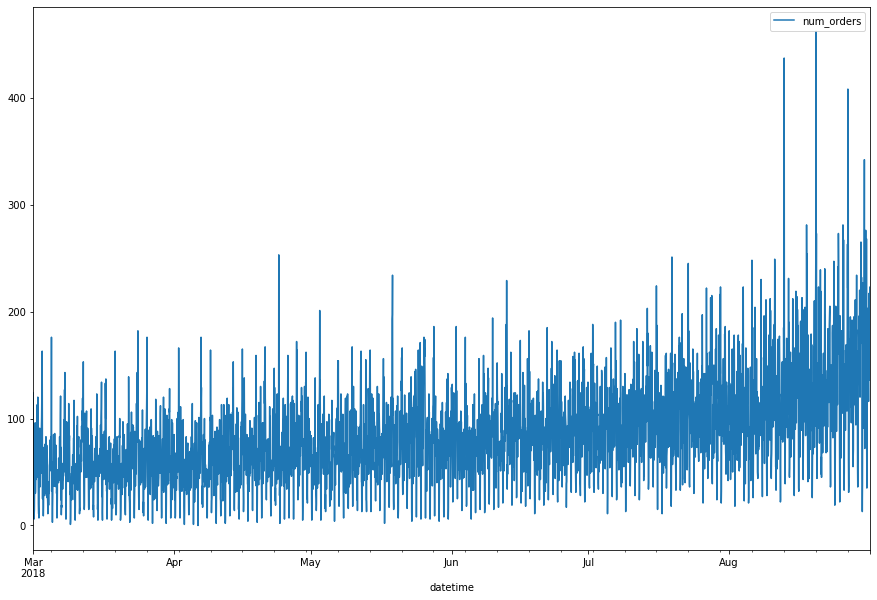

In [11]:
taxi_data.plot(figsize=(15,10))

На таком графике ничего особенно не видно.

##### Изучим тренды и сезонность:

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [13]:
decomposed = seasonal_decompose(taxi_data)

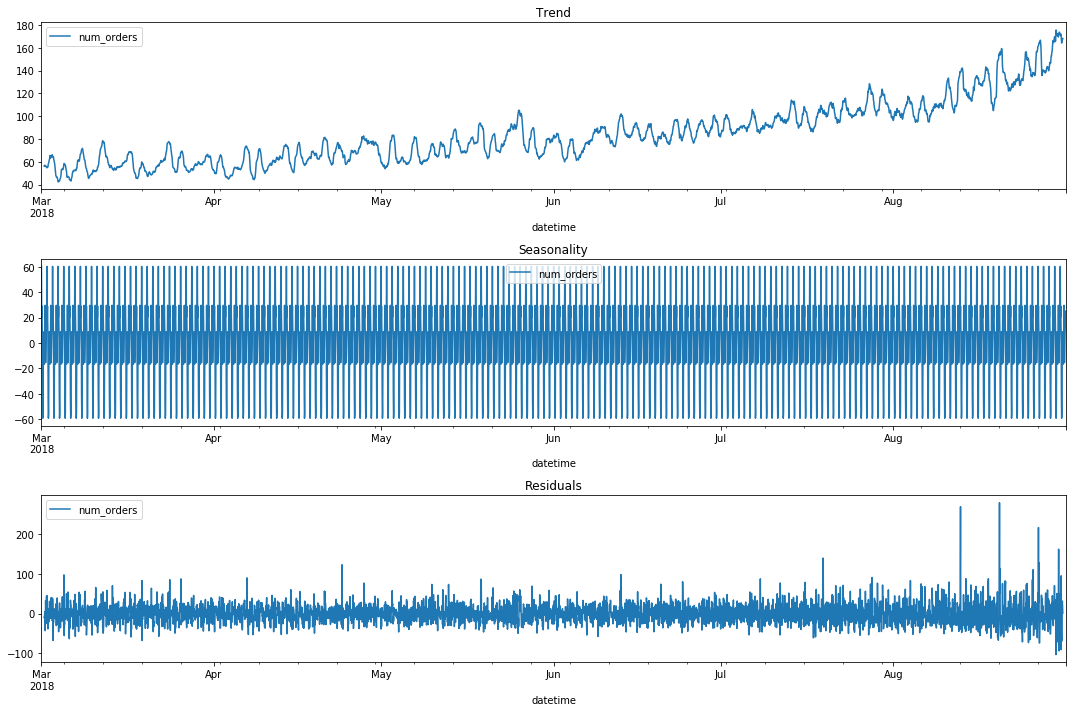

In [14]:
plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Видим восходящий тренд, к лету заказов больше. По сезонности график не понятный. 

Построим график сезонной составляющей 30-31 августа 2018 года:

Text(0.5, 1.0, 'Seasonality')

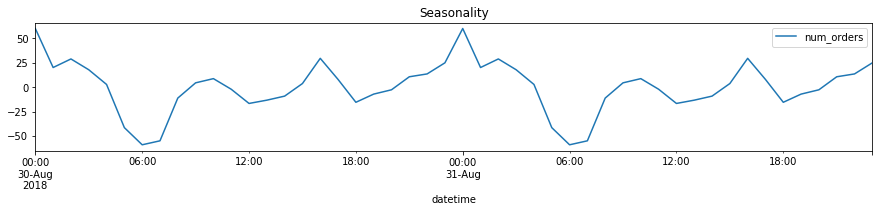

In [15]:
plt.figure(figsize=(15, 8))
plt.subplot(311)
decomposed.seasonal['2018-08-30':'2018-08-31'].plot(ax=plt.gca())
plt.title('Seasonality')

Видим, что в течение дня минимальное количество заказов в 6 утра, далее количество заказов увеличивается и максимальное количество заказов в 12 ночи.

##### Вычислим скользящее среднее:

In [16]:
taxi_data['rolling_mean'] = taxi_data['num_orders'].rolling(15).mean()

И скользящее стандартное отклонение:

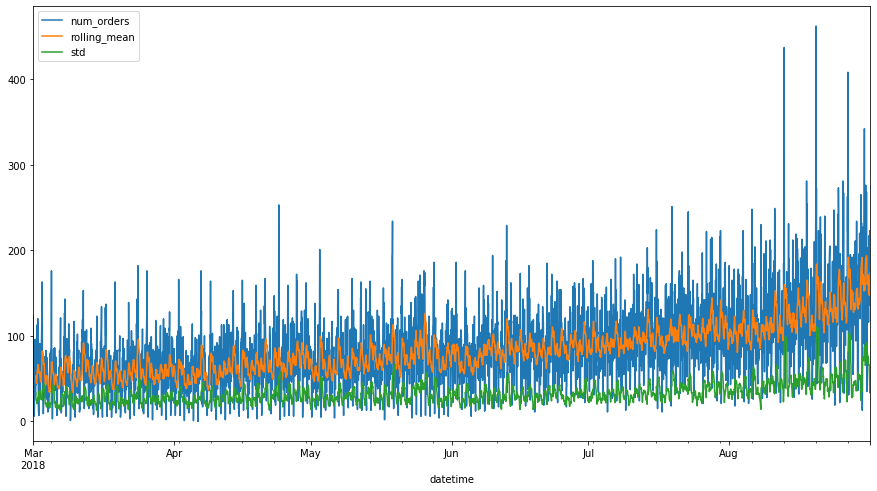

In [17]:
taxi_data['std'] = taxi_data['num_orders'].rolling(15).std()
taxi_data.plot(figsize=(15, 8))

In [3]:
#taxi_data

##### Сделаем ряд стационарным.

Для этого найдём разности его значений:

In [19]:
taxi_data -= taxi_data.shift()

In [20]:
taxi_data['mean'] = taxi_data['num_orders'].rolling(15).mean()
taxi_data['std'] = taxi_data['num_orders'].rolling(15).std()

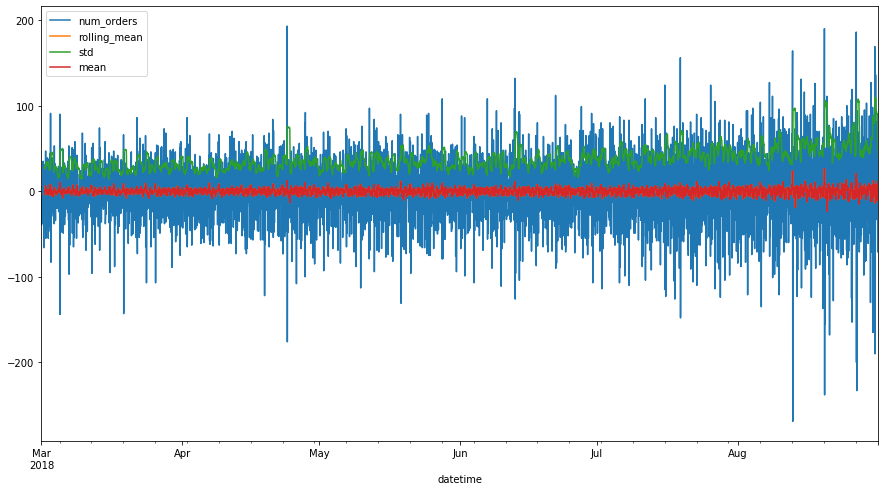

In [21]:
taxi_data.plot(figsize=(15, 8))

Видим, что ряд стал более стационарным,значит данные можно прогнозировать.

Посмотрим какая получилась таблица:

In [4]:
#taxi_data

Удалим столбцы std, mean, не будем их использовать для обучения.

In [23]:
taxi_data= taxi_data.drop(['std', 'mean'], axis=1)

# 3. Обучение

#### Создадим признаки:

1. Календарные признаки.
2. «Отстающие значения» -  это предыдущие значения временного ряда,  они подскажут, будет ли функция расти или уменьшаться. 
3. Скользящее среднее. Скользящее среднее как признак задаёт общий тренд временного ряда.

In [24]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['is_weekend'] = data.dayofweek.isin([5,6])*1
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)   
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).sum()  

In [25]:
make_features(taxi_data, 30, 100) 

#### Создадим обучающую и тестовую выборки. 

Перемешивать выборки в задаче прогнозирования временного ряда нельзя, поэтому укажем аргумент shuffle=False, чтобы разделить данные корректно. Сделаем тестовую выборку размером 10% от исходных данных:

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
train, test = train_test_split(taxi_data, shuffle=False, test_size=0.1)

Удалим пропуски:

In [28]:
train = train.dropna()

Посмотрим на какие временняе интервалы разбились данные:

In [29]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-05 05:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [30]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

#### Обучим разные модели с различными гиперпараметрами. 

##### Линейная регрессия.

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [32]:
model_LinearRegression = LinearRegression()
model_LinearRegression.fit(features_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
mean_squared_error(target_train, model_LinearRegression.predict(features_train))**0.5

25.557390593142294

##### Случайный лес.

In [34]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer

Создадим функцию для RMSE и свой скорер:

In [35]:
def RMSE(target, prediction):
    return np.sqrt(mean_squared_error(target, prediction))
my_scorer = make_scorer(RMSE, greater_is_better = False)

In [36]:
model_RandomForest = RandomForestRegressor(random_state=12345)
param_search = {'max_depth' : [3, 20], 'n_estimators': [10, 100]}

In [37]:
tscv = TimeSeriesSplit(n_splits=2)
RandomForest_GridSearch = GridSearchCV(estimator=model_RandomForest, cv=tscv,
                        param_grid=param_search, scoring=my_scorer)
RandomForest_GridSearch.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False,
                                             random_state=12345, verbose=0,
                                             warm_st

In [38]:
RandomForest_GridSearch.best_score_

-29.78747269441223

In [39]:
RandomForest_GridSearch.best_params_

{'max_depth': 20, 'n_estimators': 100}

#### Xgboost

In [40]:
import xgboost as xgb
import warnings

In [41]:
model_XGB = xgb.XGBRegressor()
param_search = {'max_depth' : [10, 100]}

In [42]:
warnings.filterwarnings('ignore')

In [43]:
tscv = TimeSeriesSplit(n_splits=2)
XGB_GridSearch = GridSearchCV(estimator=model_XGB, cv=tscv,
                        param_grid=param_search, scoring=my_scorer)
XGB_GridSearch.fit(features_train, target_train)

[20:04:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:05:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:05:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
             error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=None, param_grid={'max_depth': [10, 100]},
             pre_dispatch

In [44]:
warnings.filterwarnings('default')

In [45]:
XGB_GridSearch.best_score_

-29.916008660341827

In [46]:
XGB_GridSearch.best_params_

{'max_depth': 10}

# 4. Тестирование

In [47]:
summary = pd.DataFrame(index=['linear', 'RandomForest', 'xgboost'])
summary['best_score_RMSE_train'] = [mean_squared_error(target_train, model_LinearRegression.predict(features_train))**0.5, 
                                    RandomForest_GridSearch.best_score_, 
                                    XGB_GridSearch.best_score_ ]
summary['best_score_RMSE_test'] = [mean_squared_error(target_test, model_LinearRegression.predict(features_test))**0.5, 
                                   mean_squared_error(target_test, RandomForest_GridSearch.predict(features_test))**0.5, 
                                   mean_squared_error(target_test, XGB_GridSearch.predict(features_test))**0.5 ]
summary.round(2)

,best_score_RMSE_train,best_score_RMSE_test
linear,25.56,44.84
RandomForest,-29.79,46.06
xgboost,-29.92,46.50


На тестовой выборке лучшее качество показала линейная регрессия. RMSE = 44.8, это меньше чем 48, заданного в условии проекта. При этом были созданы признаки для обучения с параметрами max_lag = 30 , rolling_mean_size = 100.

# Вывод.

Задачей данного проекта было создание модели для предсказания количества заказов такси на следующий час . Была проведена работа по предобработке и анализу исходных данных. Созданы дополнительные признаки. Были построены и обучены следующие модели машинного обучения: LinearRegression, RandomForestRegressor, Xgboost с применением перебора параметров по сетке с помощью GridSearchCV. В качестве метрики качества выбрана RMSE. Моделью с лучшей метрикой качества оказалась LinearRegression.